In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape
from keras.models import Model
from keras import backend as K, datasets
from keras.utils import plot_model

# Get the Data

In [2]:
# load fashion_mnist dataset from tensorflow into a train and test dictionaries
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [3]:
train_emander = {'images': train_images, 'labels': train_labels}
test_emander = {'images': test_images, 'labels': test_labels}

# Data Pre-preprocessing

In [4]:
# Take the largest pixel value for normalization
combined_images = np.concatenate((train_emander['images'], test_emander['images']), axis=0) 
largest_px_value = np.amax(combined_images)
print(f"Largest Pixel Value: {largest_px_value}")

Largest Pixel Value: 255


In [5]:
# Normalize the pixel values to range of 0-1
train_emander['images'] = train_emander['images'] / largest_px_value
test_emander['images'] = test_emander['images'] / largest_px_value

In [6]:
# Print the shapes of my datasets
print(f"train_emander images Data: {train_emander['images'].shape}")
print(f"test_emander images Data: {test_emander['images'].shape}")

train_emander images Data: (60000, 28, 28)
test_emander images Data: (10000, 28, 28)


# Build Variational Autoencoder with latent dimension size of 2

In [7]:
class SampleLayer(tf.keras.layers.Layer):
    def call(self, args):
        z_mean, z_log_sigma = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape =(batch, dim))
        return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

In [8]:
latent_dim = 2 # Number of latent dim parameters

image_size = train_emander['images'].shape[1]
input_img = Input(shape=(image_size, image_size, 1),)

layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same")(input_img)
layer2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',strides=2)(layer1)
layer3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layer2)
layer4 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layer3)

conv_shape = K.int_shape(layer4)

x = Flatten()(layer4)
layer5 = Dense(32, activation='relu')(x)

z_mu_emander = Dense(latent_dim)(layer5)  #Mean values of encoded input
z_log_sigma_emander = Dense(latent_dim)(layer5)  #Std dev. (variance) of encoded input

z_emander = SampleLayer()([z_mu_emander, z_log_sigma_emander])

encoder_emander = Model(input_img, [z_mu_emander, z_log_sigma_emander, z_emander])
print(encoder_emander.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                             

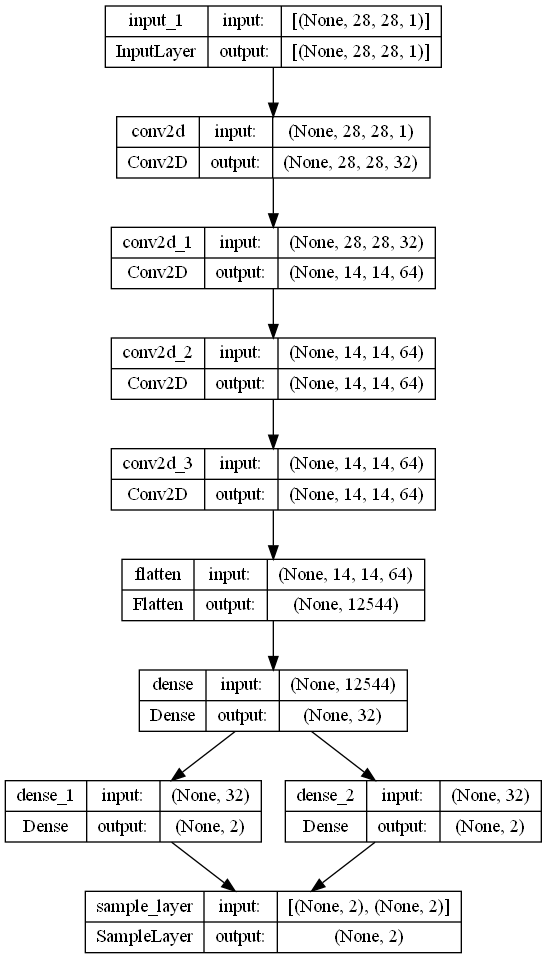

In [9]:
# Draw the diagram for the summary
plot_model(encoder_emander, show_shapes=True, show_layer_names=True)

In [10]:
# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ))

layer1 = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder
layer2 = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(layer1)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
layer3 = Conv2DTranspose(32, kernel_size=3, padding='same', activation='relu',strides=(2, 2))(layer2) 
#Using sigmoid activation
layer4 = Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')(layer3)

# Define and summarize decoder model
decoder_emander = Model(decoder_input, layer4, name='decoder')
decoder_emander.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 32)        18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 1)         289       
 Transpose)                                                      
                                                                 
Total params: 56385 (220.25 KB)
Trainable params: 56385 (22

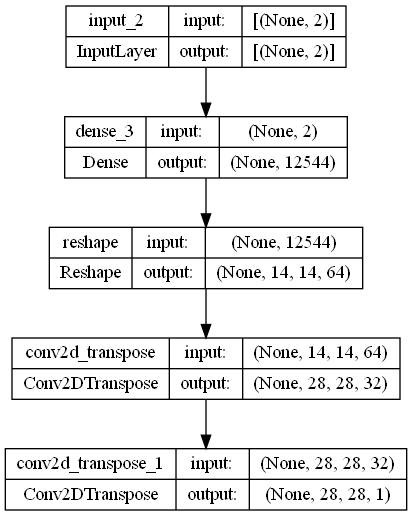

In [11]:
# Draw the diagram for the summary
plot_model(decoder_emander, show_shapes=True, show_layer_names=True)

In [12]:
y = decoder_emander(encoder_emander(input_img)[2])
vae_emander = Model(input_img, y, name='vae')
vae_emander.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          [(None, 2),               494244    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56385     
                                                                 
Total params: 550629 (2.10 MB)
Trainable params: 550629 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


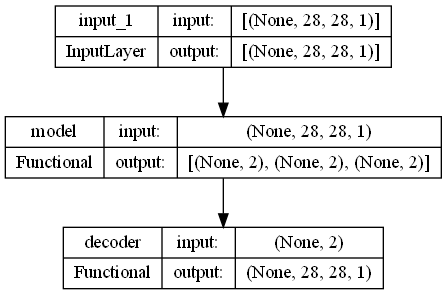

In [13]:
tf.keras.utils.plot_model(vae_emander, show_shapes=True, show_layer_names=True)

# Define the KL divergence

In [14]:
kl_loss = -0.5 * tf.reduce_mean(z_mu_emander - tf.square(z_mu_emander) - tf.exp(z_log_sigma_emander) + 1)
kl_loss *= 0.5

Use model.add_loss() to add the KL loss function defined in Step D.

# Compile the model

In [15]:
# Compile VAE
vae_emander.add_loss(kl_loss)
vae_emander.compile(optimizer='adam', loss='mean_squared_error')

# Train the VAE model

In [16]:
# Train autoencoder
vae_emander.fit(train_emander['images'],train_emander['images'], epochs = 10, batch_size=256)

Epoch 1/10

235/235 [==============================] - 52s 206ms/step - loss: -0.2135
Epoch 2/10
235/235 [==============================] - 45s 192ms/step - loss: -0.2523
Epoch 3/10
235/235 [==============================] - 45s 191ms/step - loss: -0.2640
Epoch 4/10
235/235 [==============================] - 47s 200ms/step - loss: -0.2662
Epoch 5/10
235/235 [==============================] - 45s 192ms/step - loss: -0.2676
Epoch 6/10
235/235 [==============================] - 45s 191ms/step - loss: -0.2686
Epoch 7/10
235/235 [==============================] - 45s 192ms/step - loss: -0.2694
Epoch 8/10
235/235 [==============================] - 46s 197ms/step - loss: -0.2700
Epoch 9/10
235/235 [==============================] - 45s 194ms/step - loss: -0.2705
Epoch 10/10
235/235 [==============================] - 45s 194ms/step - loss: -0.2711


# Review sample code

1/1 [==============================] - 0s 35ms/step


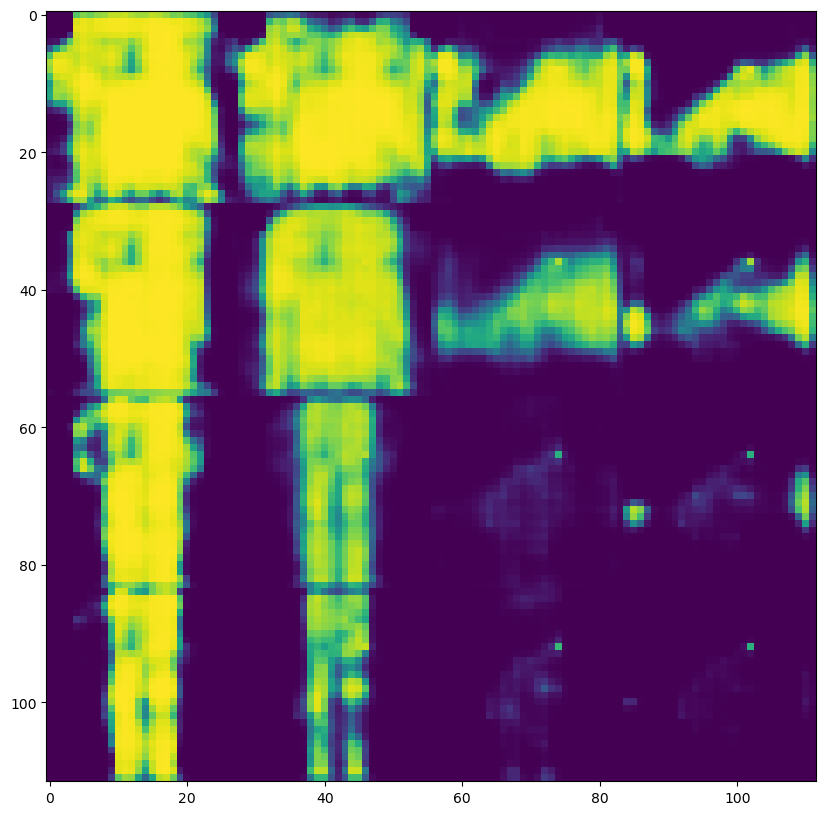

In [17]:
n = 4
figure_size = 28

figure = np.zeros((figure_size * n, figure_size * n))

grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])

        x_decoded = decoder_emander.predict(z_sample)
        img = x_decoded[0].reshape(28, 28)
        figure[i * figure_size: (i + 1) * figure_size,
               j * figure_size: (j + 1) * figure_size] = img

plt.figure(figsize=(10, 10))

#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure)
plt.show()

# Display (plot) the latent space

313/313 [==============================] - 2s 7ms/step


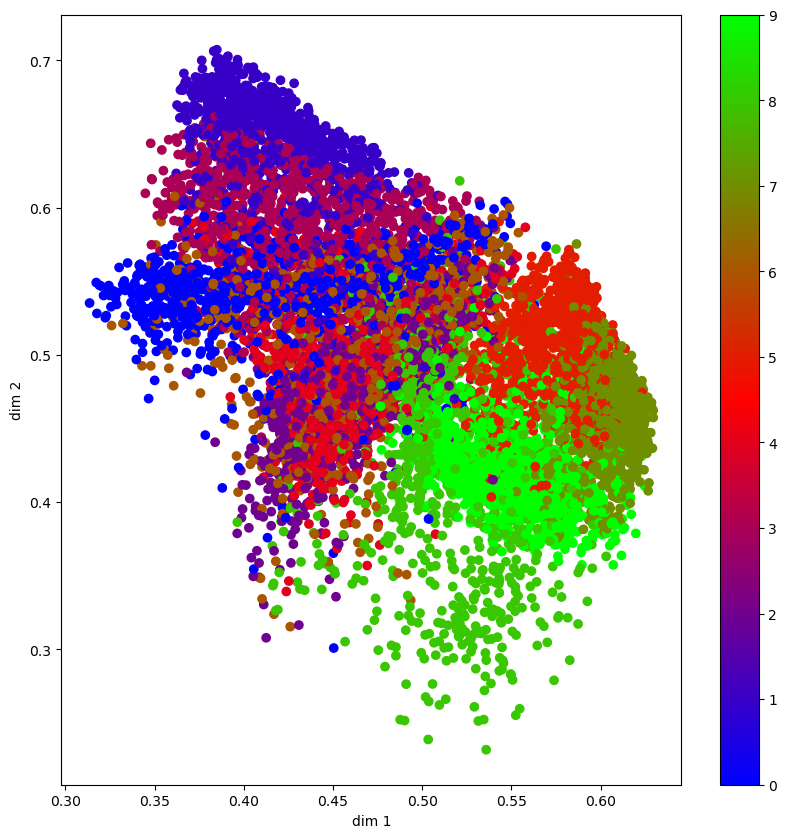

In [18]:
mu, _, _ = encoder_emander.predict(test_emander['images'])
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=test_emander['labels'], cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show() 